In [ ]:
! pip install POT

In [ ]:
! pip install lda

In [ ]:
import numpy as np
import lda
import nltk
from sklearn.metrics.pairwise import euclidean_distances
from scipy.io import loadmat
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from scipy.special import kl_div
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import json
import ot
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import time

# HOTT.py

In [ ]:
import ot
import numpy as np

def sparse_ot(weights1, weights2, M):
    """ Compute transport for (posssibly) un-normalized sparse distributions"""

    weights1 = weights1/weights1.sum()
    weights2 = weights2/weights2.sum()

    active1 = np.where(weights1)[0]
    active2 = np.where(weights2)[0]

    weights_1_active = weights1[active1]
    weights_2_active = weights2[active2]
    M_reduced = np.ascontiguousarray(M[active1][:,active2])

    return ot.emd2(weights_1_active,weights_2_active,M_reduced)

def topic_ot(weights1, weights2, M):

    return ot.emd2(weights1,weights2,M)
def hott(p, q, C, threshold=None):
    """ Hierarchical optimal topic transport."""

    # Avoid changing p and q outside of this function
    p, q = np.copy(p), np.copy(q)

    k = len(p)
    if threshold is None:
        threshold = 1. / (k + 1)

    p[p<threshold] = 0
    q[q<threshold] = 0

    return sparse_ot(p, q, C)


def hoftt(p, q, C):
    """ Hierarchical optimal full topic transport."""
    return ot.emd2(p, q, C)


# data.py

In [ ]:



def load_wmd_data(path):
    """Load data used in the WMD paper.
    """
    mat_data = loadmat(path, squeeze_me=True, chars_as_strings=True)

    try:
        y = mat_data['Y'].astype(np.int)
    except KeyError:
        y = np.concatenate((mat_data['ytr'].astype(np.int),
                            mat_data['yte'].astype(np.int)))
    try:
        embeddings_of_doc_words = mat_data['X']
    except KeyError:
        embeddings_of_doc_words = np.concatenate((mat_data['xtr'],
                                                  mat_data['xte']))
    try:
        doc_word_counts = mat_data['BOW_X']
    except KeyError:
        doc_word_counts = np.concatenate((mat_data['BOW_xtr'], mat_data['BOW_xte']))
    try:
        doc_words = mat_data['words']
    except KeyError:
        doc_words = np.concatenate((mat_data['words_tr'], mat_data['words_te']))

    vocab = []
    embed_vocab = {}
    for d_w, d_e in zip(doc_words, embeddings_of_doc_words):
        if type(d_w) == str:
            d_w = [d_w]
        words = [w for w in d_w if type(w) == str]
        if len(words) == 1:
            d_e = d_e.reshape((-1, 1))
        for i, w in enumerate(words):
            if w not in vocab:
                vocab.append(w)
                embed_vocab[w] = d_e[:, i]
            else:
                if not np.allclose(embed_vocab[w], d_e[:, i]):
                    print('Problem with embeddings')
                    break

    bow_data = np.zeros((len(doc_word_counts), len(vocab)),
                        dtype=np.int)
    for doc_idx, (d_w, d_c) in enumerate(zip(doc_words, doc_word_counts)):
        if type(d_w) == str:
            d_w = [d_w]
        words = [w for w in d_w if type(w) == str]
        if len(words) == 1:
            d_c = np.array([d_c])
        words_idx = np.array([vocab.index(w) for w in words])
        bow_data[doc_idx, words_idx] = d_c.astype(np.int)

    return vocab, embed_vocab, bow_data, y


def reduce_vocab(bow_data, vocab, embed_vocab, embed_aggregate='mean'):
    """Reduce vocabulary size by stemming and removing stop words.
    """
    nltk.download('stopwords')
    vocab = np.array(vocab)
    short = np.array([len(w) > 2 for w in vocab])
    stop_words = set(stopwords.words('english'))
    stop = np.array([w not in stop_words for w in vocab])
    reduced_vocab = vocab[np.logical_and(short, stop)]
    reduced_bow_data = bow_data[:, np.logical_and(short, stop)]
    stemmer = SnowballStemmer("english")
    stemmed_dict = {}
    stemmed_idx_mapping = {}
    stemmed_vocab = []
    for i, w in enumerate(reduced_vocab):
        stem_w = stemmer.stem(w)
        if stem_w in stemmed_vocab:
            stemmed_dict[stem_w].append(w)
            stemmed_idx_mapping[stemmed_vocab.index(stem_w)].append(i)
        else:
            stemmed_dict[stem_w] = [w]
            stemmed_vocab.append(stem_w)
            stemmed_idx_mapping[stemmed_vocab.index(stem_w)] = [i]

    stemmed_bow_data = np.zeros((bow_data.shape[0], len(stemmed_vocab)),
                                dtype=np.int)
    for i in range(len(stemmed_vocab)):
        stemmed_bow_data[:, i] = reduced_bow_data[:, stemmed_idx_mapping[i]].sum(axis=1).flatten()

    word_counts = stemmed_bow_data.sum(axis=0)
    stemmed_reduced_vocab = np.array(stemmed_vocab)[word_counts > 2].tolist()
    stemmed_reduced_bow_data = stemmed_bow_data[:, word_counts > 2]

    stemmed_reduced_embed_vocab = {}
    for w in stemmed_reduced_vocab:
        old_w_embed = [embed_vocab[w_old] for w_old in stemmed_dict[w]]
        if embed_aggregate == 'mean':
            new_w_embed = np.mean(old_w_embed, axis=0)
        elif embed_aggregate == 'first':
            new_w_embed = old_w_embed[0]
        else:
            print('Unknown embedding aggregation')
            break
        stemmed_reduced_embed_vocab[w] = new_w_embed

    return (stemmed_reduced_vocab,
            stemmed_reduced_embed_vocab,
            stemmed_reduced_bow_data)


def get_embedded_data(bow_data, embed_vocab, vocab):
    """Map bag-of-words data to embedded representation."""
    M, V = bow_data.shape
    embed_data = [[] for _ in range(M)]
    for i in range(V):
        for d in range(M):
            if bow_data[d, i] > 0:
                for _ in range(bow_data[d, i]):
                    embed_data[d].append(embed_vocab[vocab[i]])
    return [np.array(embed_doc) for embed_doc in embed_data]


def change_embeddings(vocab, bow_data, embed_path):
    """Change embedding data if vocabulary has been reduced."""
    all_embed_vocab = {}
    with open(embed_path, 'r') as file:
        for line in file.readlines():
            word = line.split(' ')[0]
            embedding = [float(x) for x in line.split(' ')[1:]]
            all_embed_vocab[word] = embedding

    data_embed_vocab = {}
    new_vocab_idx = []
    new_vocab = []
    for i, w in enumerate(vocab):
        if w in all_embed_vocab:
            data_embed_vocab[w] = all_embed_vocab[w]
            new_vocab_idx.append(i)
            new_vocab.append(w)
    bow_data = bow_data[:, new_vocab_idx]
    return new_vocab, data_embed_vocab, bow_data


def fit_topics(data, embeddings, vocab, K):
    """Fit a topic model to bag-of-words data."""
    model = lda.LDA(n_topics=K, n_iter=1500, random_state=1)
    model.fit(data)
    topics = model.topic_word_
    lda_centers = np.matmul(topics, embeddings)
    print('LDA Gibbs topics')
    n_top_words = 20
    for i, topic_dist in enumerate(topics):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
        topic_name = topic_words[0]
        print(f'{topic_name}: {", ".join(topic_words)}')
    print('\n')
    topic_proportions = model.doc_topic_

    return topics, lda_centers, topic_proportions

def loader(data_path,
           embeddings_path,
           p=1,
           K_lda=30,
           glove_embeddings=True,
           stemming=True,
           n_words_keep = None):
    """ Load dataset and embeddings from data path."""
    # Load dataset from data_path
    vocab, embed_vocab, bow_data, y = load_wmd_data(data_path)
    y = y - 1

    # Use GLOVE word embeddings
    if glove_embeddings:
        vocab, embed_vocab, bow_data = change_embeddings(
            vocab, bow_data, embeddings_path)
    # Reduce vocabulary by removing short words, stop words, and stemming
    if stemming:
        vocab, embed_vocab, bow_data = reduce_vocab(
            bow_data, vocab, embed_vocab, embed_aggregate='mean')

    # Matrix of word embeddings
    embeddings = np.array([embed_vocab[w] for w in vocab])

    topics, lda_centers, topic_proportions = fit_topics(
        bow_data, embeddings, vocab, K_lda)

    cost_embeddings = euclidean_distances(embeddings, embeddings) ** p
    cost_topics = np.zeros((topics.shape[0], topics.shape[0]))

    ## Reduce topics to top-20 words
    if n_words_keep is not None:
        for k in range(K_lda):
            to_0_idx = np.argsort(-topics[k])[n_words_keep:]
            topics[k][to_0_idx] = 0


    for i in range(cost_topics.shape[0]):
        for j in range(i + 1, cost_topics.shape[1]):
            cost_topics[i, j] = sparse_ot(topics[i], topics[j], cost_embeddings)
    cost_topics = cost_topics + cost_topics.T

    out = {'X': bow_data, 'y': y,
           'embeddings': embeddings,
           'topics': topics, 'proportions': topic_proportions,
           'cost_E': cost_embeddings, 'cost_T': cost_topics}

    return out

# knn_classifier.py

In [ ]:
import numpy as np


def predict(neighbor_classes, C):
    # Make sure all classes are considered
    labels = np.concatenate((neighbor_classes, list(range(C))))
    # Find class frequency among neighbors
    weights = np.unique(labels, return_counts=True)[1]
    # Find most popular class
    prediction = np.argmax(weights)

    # If most popular class is ambiguous try with fewer neighbors; else return
    if sum(weights[prediction] == weights) > 1:
        return predict(neighbor_classes[:-2], C)

    else:
        return prediction


def knn(X_train, X_test, y_train, y_test, method, C, n_neighbors=3):
    # Number of classes
    n_classes = len(np.unique(y_train))

    prediction = []
    for doc in X_test:
        doc_to_train = [method(doc, x, C) for x in X_train]
        # Find indices of n_neighbors closest documents
        rank = np.argsort(doc_to_train)[:n_neighbors]

        # Make prediction based on most popular class among neighbors
        prediction.append(predict(y_train[rank], n_classes))

    # Print and return test error
    test_error = 1 - (prediction == y_test).mean()
    return test_error, prediction


# main.py

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import time
#from knn_classifier import knn

#import distances
#import hott

# Download datasets used by Kusner et al from
# https://www.dropbox.com/sh/nf532hddgdt68ix/AABGLUiPRyXv6UL2YAcHmAFqa?dl=0
# and put them into
data_path = ''


# Download GloVe 6B tokens, 300d word embeddings from
# https://nlp.stanford.edu/projects/glove/
# and put them into
embeddings_path = '/content/drive/MyDrive/projet_ot/glove.6B.300d.txt'

# Pick a dataset (uncomment the line you want)
data_name = '/content/drive/MyDrive/projet_ot/bbcsport-emd_tr_te_split.mat'

# p=1 for W1 and p=2 for W2
p = 1
data = loader(data_name, embeddings_path, p=p)
print(data)
cost_E = data['cost_E']
cost_T = data['cost_T']
data['topics']

<ipython-input-5-d16ca4986818>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = mat_data['Y'].astype(np.int)


KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming data['topics'] is a 2D NumPy array
data['topics'] = data['topics'] + np.random.randn(data['topics'].shape[0], data['topics'].shape[1])+ np.random.randn(data['topics'].shape[0], data['topics'].shape[1])

# Create a MinMaxScaler
#scaler = MinMaxScaler()

# Fit and transform the 'topics' data
#data['topics'] = scaler.fit_transform(data['topics'])


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming data['topics'] is a 2D NumPy array
data['X'] = data['X'] + np.random.randn(data['X'].shape[0], data['X'].shape[1])


# Save datasets

In [ ]:
# Dataset 70 topics and sparse déjà enregitré avec ça
cost_L1_topics = np.zeros((data["topics"].shape[0], data["topics"].shape[0]))
for i in range(data['topics'].shape[0]):
        for j in range(i + 1, data['topics'].shape[0]):
            cost_L1_topics[i, j] = np.linalg.norm(data["topics"][i] - data["topics"][j])
cost_L1_topics = cost_L1_topics + cost_L1_topics.T
data['cost_L1'] = cost_L1_topics

In [ ]:
# Dataset 70 topics and sparse déjà enregitré avec ça
cost_ot_topics = np.zeros((data["topics"].shape[0], data["topics"].shape[0]))
for i in range(data['topics'].shape[0]):
        for j in range(i + 1, data['topics'].shape[0]):
            cost_ot_topics[i, j] = ot.emd2(data["topics"][i],data["topics"][j], data['cost_E'])
cost_ot_topics = cost_ot_topics + cost_ot_topics.T
data['cost_OT'] = cost_ot_topics

AssertionError: 
Arrays are not almost equal to 6 decimals
a and b vector must have the same sum
Mismatched elements: 1 / 1 (100%)
Max absolute difference: 7.20696921
Max relative difference: 0.00390853
 x: array(1851.114894)
 y: array([1843.907925])

In [ ]:
data_converted = {key: value.tolist() if isinstance(value, np.ndarray) else value for key, value in data.items()}

# Enregistrer le dictionnaire
import json

# Enregistrer le dictionnaire dans un fichier JSON
with open('/content/drive/MyDrive/projet_ot/dataset_words_30.json', 'w') as fichier:
    json.dump(data_converted, fichier)

NameError: name 'data' is not defined

In [ ]:
with open('/content/drive/MyDrive/projet_ot/dataset_words_30.json', 'r') as fichier:
    loaded_data = json.load(fichier)

# Convertir les listes en numpy arrays si nécessaire
data = {key: np.array(value) if isinstance(value, list) else value for key, value in loaded_data.items()}


JSONDecodeError: Expecting ',' delimiter: line 1 column 65409586 (char 65409585)

In [ ]:
bow_data, y = data['X'], data['y']
topic_proportions = data['proportions']

seed = 0
bow_train, bow_test, topic_train, topic_test, y_train, y_test = train_test_split(bow_data, topic_proportions, y, random_state=seed)

methods = {'HOTT': hoftt, 'L1_W1': hoftt}

for method in methods.keys():

    t_s = time.time()
    # Compute HOTT distance
    if method == 'HOTT':
      X_train, X_test = topic_train, topic_test
      C = data['cost_T']

    # Compute test error
      test_error, prediction_HOTT = knn(X_train, X_test, y_train, y_test, methods[method], C, n_neighbors=7)
      print(method + ' test error is %f; took %.2f seconds' % (test_error, time.time()-t_s))
      t_s = time.time()

    #Compute L1 then Wasserstein distance
    if method == 'L1_W1':
      X_train, X_test = topic_train, topic_test
      C = data['cost_L1']

    # Compute test error
      test_error, prediction_L1_W1 = knn(X_train, X_test, y_train, y_test, methods[method], C, n_neighbors=7)
      print(method + ' test error is %f; took %.2f seconds' % (test_error, time.time()-t_s))
      t_s = time.time()

# Done!

HOTT test error is 0.048649; took 80.19 seconds
L1_W1 test error is 0.054054; took 51.29 seconds


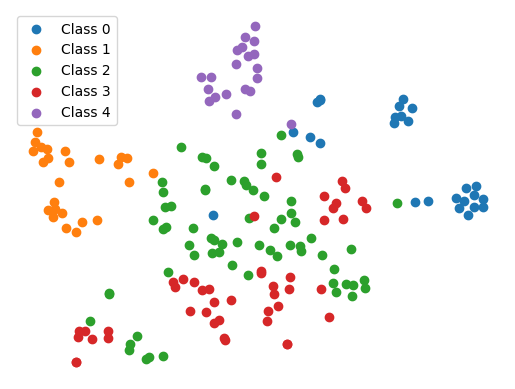

In [ ]:
# Apply t-SNE for dimensionality reduction to 2D
predicted_HOTT = np.array(prediction_HOTT)
predicted_L1_W1 = np.array(prediction_L1_W1)
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test)

# Create a scatter plot
plt.figure()

# Get unique labels from y_test
unique_labels = np.unique(y_test)

# Plot the points with different colors for each class
for label in unique_labels:
    indices = np.where(y_test == label)
    plt.scatter(X_test_tsne[indices, 0], X_test_tsne[indices, 1], label=f'Class {label}')

#plt.title('t-SNE Visualization of X_test')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')

# Add legend
plt.axis("off")
plt.legend()
plt.savefig("true_values.png")
plt.show()


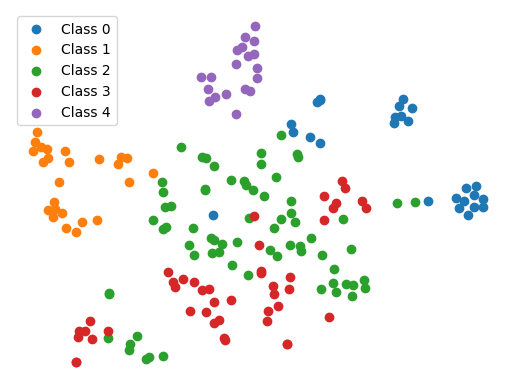

In [ ]:
# Create a scatter plot
plt.figure()

# Get unique labels from y_test
unique_labels = np.unique(predicted_HOTT)

# Plot the points with different colors for each class
for label in unique_labels:
    indices = np.where(predicted_HOTT == label)
    plt.scatter(X_test_tsne[indices, 0], X_test_tsne[indices, 1], label=f'Class {label}')

#plt.title('t-SNE Visualization of X_test')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')

# Add legend
plt.axis("off")
plt.legend()
plt.savefig("HOTT_values.png")
plt.show()

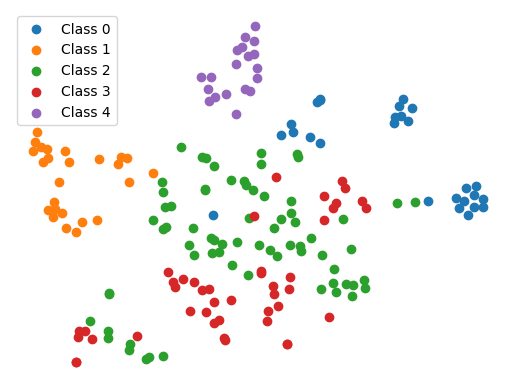

In [ ]:
# Create a scatter plot
plt.figure()

# Get unique labels from y_test
unique_labels = np.unique(predicted_L1_W1)

# Plot the points with different colors for each class
for label in unique_labels:
    indices = np.where(predicted_L1_W1 == label)
    plt.scatter(X_test_tsne[indices, 0], X_test_tsne[indices, 1], label=f'Class {label}')

#plt.title('t-SNE Visualization of X_test')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')

# Add legend
plt.axis("off")
plt.legend()
plt.savefig("L1_values.png")
plt.show()

In [ ]:
# KL + OT
def kl(p, q):

    return np.sum(np.where((p != 0), p * np.log(p / q), 0))

cost_KL_topics = np.zeros((data["topics"].shape[0], data["topics"].shape[0]))
for i in range(data['topics'].shape[0]):
        for j in range(i + 1, data['topics'].shape[0]):
            cost_KL_topics[i, j] = kl(data["topics"][i],data["topics"][j])
cost_KL_topics = cost_KL_topics + cost_KL_topics.T
data['cost_KL'] = cost_KL_topics
C = data['cost_KL']

    # Compute test error
test_error, prediction_KL_W1 = knn(X_train, X_test, y_train, y_test, methods[method], C, n_neighbors=7)
print(method + ' test error is %f; took %.2f seconds' % (test_error, time.time()-t_s))

<ipython-input-42-a94ee407e7da>:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where((p != 0), p * np.log(p / q), 0))
<ipython-input-42-a94ee407e7da>:4: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where((p != 0), p * np.log(p / q), 0))
<ipython-input-42-a94ee407e7da>:4: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where((p != 0), p * np.log(p / q), 0))
/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning: Pr

L1_W1 test error is 0.891892; took 131.59 seconds


In [ ]:
print(data['cost_T'].shape)
print(data['cost_L1'].shape)

(30, 30)
(30, 30)


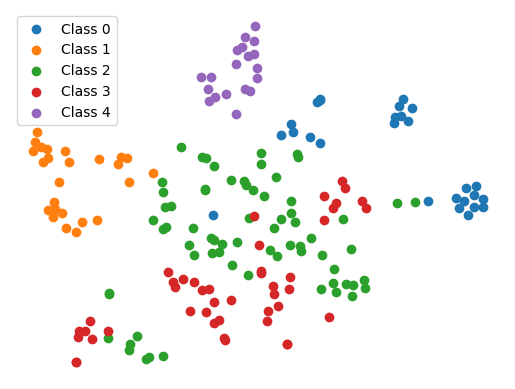

In [ ]:
from matplotlib.lines import Line2D
predicted_KL_W1 = np.array(prediction_KL_W1)

plt.figure()

# Get unique labels from y_test
unique_labels = np.unique(predicted_KL_W1)

# Plot the points with different colors for each class
for label in unique_labels:
    indices = np.where(predicted_KL_W1 == label)
    plt.scatter(X_test_tsne[indices, 0], X_test_tsne[indices, 1], label=f'Class {label}')

#plt.title('t-SNE Visualization of X_test')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')

# Add legend
plt.axis("off")
plt.legend()
plt.savefig("KL_values.png")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score

# Assuming predicted_HOTT is a 1D array of predicted labels
accuracy = accuracy_score(y_test, predicted_HOTT)
precision_micro = precision_score(y_test, predicted_HOTT, average='micro')
recall_micro = recall_score(y_test, predicted_HOTT, average='micro')
print(f'Accuracy HOTT: {accuracy * 100:.2f}%')
print(f'Recall HOTT: {recall_micro * 100:.2f}%')
print(f'Precision HOTT: {precision_micro * 100:.2f}%')
accuracy = accuracy_score(y_test, predicted_L1_W1)
precision_micro = precision_score(y_test, predicted_L1_W1, average='micro')
recall_micro = recall_score(y_test, predicted_L1_W1, average='micro')
print(f'Accuracy L1-OT: {accuracy * 100:.2f}%')
print(f'Recall L1-OT: {recall_micro * 100:.2f}%')
print(f'Precision L1-OT: {precision_micro * 100:.2f}%')
# Assuming predicted_HOTT is a 1D array of predicted labels
accuracy = accuracy_score(y_test, predicted_KL_W1)
precision_micro = precision_score(y_test, predicted_KL_W1, average='micro')
recall_micro = recall_score(y_test, predicted_KL_W1, average='micro')
print(f'Accuracy KL: {accuracy * 100:.2f}%')
print(f'Recall KL-OT: {recall_micro * 100:.2f}%')
print(f'Precision KL-OT: {precision_micro * 100:.2f}%')

Accuracy HOTT: 97.84%
Recall HOTT: 97.84%
Precision HOTT: 97.84%
Accuracy L1-OT: 96.76%
Recall L1-OT: 96.76%
Precision L1-OT: 96.76%
Accuracy KL: 94.59%
Recall KL-OT: 94.59%
Precision KL-OT: 94.59%


# DATA 70

In [ ]:
print(data_70)

{'X': array([[1, 2, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'y': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [ ]:
# Get data back
file_path = '/content/drive/MyDrive/projet_ot/dataset_words.json'

# Load the data from the JSON file
with open(file_path, 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert lists back to NumPy arrays in the loaded data
data_70 = {key: np.array(value) if isinstance(value, list) else value for key, value in loaded_data.items()}


In [ ]:
print(data_70["topics"].shape)

(70, 3657)


In [ ]:
print(data_70["cost_L1"])

[[0.         1.46938776 1.22541497 ... 1.28397522 0.59619431 0.87932404]
 [1.46938776 0.         1.8807619  ... 1.89200667 1.72313883 1.80249515]
 [1.22541497 1.8807619  0.         ... 0.84250584 0.93686385 1.06772851]
 ...
 [1.28397522 1.89200667 0.84250584 ... 0.         1.17957801 1.31828794]
 [0.59619431 1.72313883 0.93686385 ... 1.17957801 0.         0.84951628]
 [0.87932404 1.80249515 1.06772851 ... 1.31828794 0.84951628 0.        ]]


In [ ]:
# Dataset 70 topics and sparse déjà enregitré avec ça
cost_L1_topics = np.zeros((data_70["topics"].shape[0], data_70["topics"].shape[0]))
for i in range(data_70['topics'].shape[0]):
        for j in range(i + 1, data_70['topics'].shape[0]):
            cost_L1_topics[i, j] = np.linalg.norm(data_70["proportions"][i] - data_70["proportions"][j], 1)
cost_L1_topics = cost_L1_topics + cost_L1_topics.T
data_70['cost_L1'] = cost_L1_topics

In [ ]:
print(bow_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
bow_data, y = data_70['X'], data_70['y']
topic_proportions = data_70['proportions']

seed = 0
bow_train, bow_test, topic_train, topic_test, y_train, y_test = train_test_split(bow_data, topic_proportions, y, random_state=seed)

methods = {'HOTT': hoftt}

for method in methods.keys():

    t_s = time.time()
    # Compute HOTT distance
    X_train, X_test = topic_train, topic_test
    C = data_70['cost_T']

    # Compute test error
    test_error, prediction_HOTT = knn(X_train, X_test, y_train, y_test, methods[method], C, n_neighbors=7)
    print(' HOTT test error is %f; took %.2f seconds' % (test_error, time.time()-t_s))
    t_s = time.time()

    #Compute L1 then Wasserstein distance
    X_train, X_test = topic_train, topic_test
    C = data_70['cost_L1']

    # Compute test error
    test_error, prediction_L1_W1 = knn(X_train, X_test, y_train, y_test, methods[method], C, n_neighbors=7)
    print(' L1 test error is %f; took %.2f seconds' % (test_error, time.time()-t_s))
    t_s = time.time()

# Done!

 HOTT test error is 0.021622; took 130.22 seconds
 L1 test error is 0.064865; took 122.51 seconds


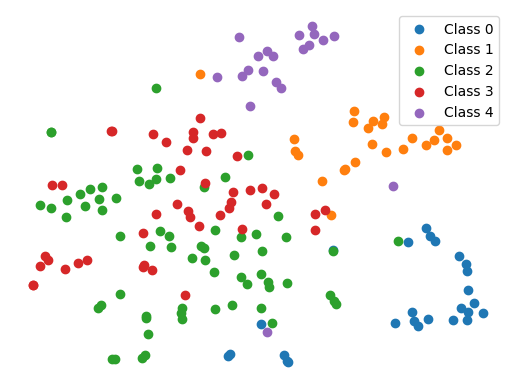

In [ ]:
# Apply t-SNE for dimensionality reduction to 2D
predicted_HOTT = np.array(prediction_HOTT)
predicted_L1_W1 = np.array(prediction_L1_W1)
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test)

# Create a scatter plot
plt.figure()

# Get unique labels from y_test
unique_labels = np.unique(y_test)

# Plot the points with different colors for each class
for label in unique_labels:
    indices = np.where(y_test == label)
    plt.scatter(X_test_tsne[indices, 0], X_test_tsne[indices, 1], label=f'Class {label}')

#plt.title('t-SNE Visualization of X_test')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')

# Add legend
plt.axis("off")
plt.legend()
plt.savefig("true_values_70.png")
plt.show()

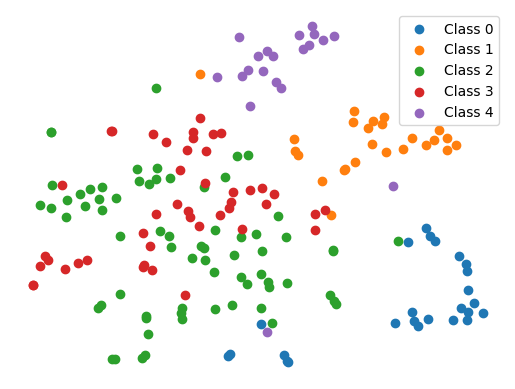

In [ ]:
# Create a scatter plot
plt.figure()

# Get unique labels from y_test
unique_labels = np.unique(predicted_HOTT)

# Plot the points with different colors for each class
for label in unique_labels:
    indices = np.where(predicted_HOTT == label)
    plt.scatter(X_test_tsne[indices, 0], X_test_tsne[indices, 1], label=f'Class {label}')

#plt.title('t-SNE Visualization of X_test')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')

# Add legend
plt.axis("off")
plt.legend()
plt.savefig("HOTT_values_70.png")
plt.show()

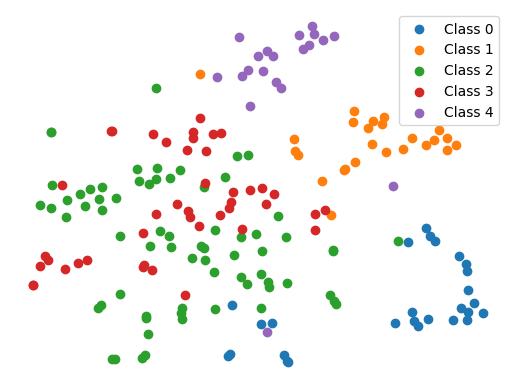

In [ ]:
# Create a scatter plot
plt.figure()

# Get unique labels from y_test
unique_labels = np.unique(predicted_L1_W1)

# Plot the points with different colors for each class
for label in unique_labels:
    indices = np.where(predicted_L1_W1 == label)
    plt.scatter(X_test_tsne[indices, 0], X_test_tsne[indices, 1], label=f'Class {label}')

#plt.title('t-SNE Visualization of X_test')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')

# Add legend
plt.axis("off")
plt.legend()
plt.savefig("L1_values_70.png")
plt.show()

In [ ]:
print(methods.keys())

dict_keys(['HOTT', 'L1_W1'])


In [ ]:
# KL + OT
def kl(p, q):

    return np.sum(np.where((p != 0), p * np.log(p / q), 0))

cost_KL_topics = np.zeros((data_70["topics"].shape[0], data_70["topics"].shape[0]))
for i in range(data_70['topics'].shape[0]):
        for j in range(i + 1, data_70['topics'].shape[0]):
            cost_KL_topics[i, j] = kl(data_70["topics"][i],data_70["topics"][j])
cost_KL_topics = cost_KL_topics + cost_KL_topics.T
data_70['cost_KL'] = cost_KL_topics
C = data_70['cost_KL']

    # Compute test error
for method in methods.keys():
  test_error, prediction_KL_W1 = knn(X_train, X_test, y_train, y_test, methods['HOTT'], C, n_neighbors=3)
  print(method + ' test error is %f; took %.2f seconds' % (test_error, time.time()-t_s))

<ipython-input-57-df7e942f0044>:4: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where((p != 0), p * np.log(p / q), 0))
<ipython-input-57-df7e942f0044>:4: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where((p != 0), p * np.log(p / q), 0))
<ipython-input-57-df7e942f0044>:4: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where((p != 0), p * np.log(p / q), 0))
<ipython-input-57-df7e942f0044>:4: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where((p != 0), p * np.log(p / q), 0))
/usr/local/lib/python3.10/dist-packages/ot/lp/__init__.py:571: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


HOTT test error is 0.632432; took 1445.92 seconds


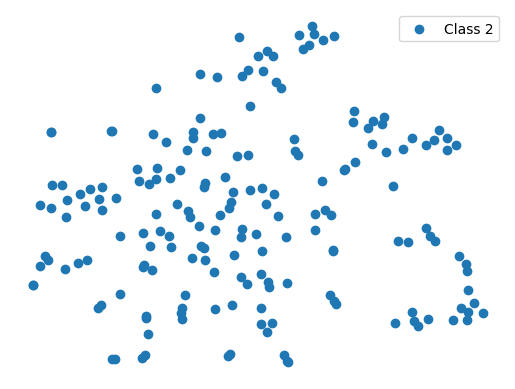

In [ ]:
from matplotlib.lines import Line2D
predicted_KL_W1 = np.array(prediction_KL_W1)

plt.figure()

# Get unique labels from y_test
unique_labels = np.unique(predicted_KL_W1)

# Plot the points with different colors for each class
for label in unique_labels:
    indices = np.where(predicted_KL_W1 == label)
    plt.scatter(X_test_tsne[indices, 0], X_test_tsne[indices, 1], label=f'Class {label}')

#plt.title('t-SNE Visualization of X_test')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')

# Add legend
plt.axis("off")
plt.legend()
plt.savefig("KL_values_70.png")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score

# Assuming predicted_HOTT is a 1D array of predicted labels
accuracy = accuracy_score(y_test, predicted_HOTT)
precision_micro = precision_score(y_test, predicted_HOTT, average='micro')
recall_micro = recall_score(y_test, predicted_HOTT, average='micro')
print(f'Accuracy HOTT: {accuracy * 100:.2f}%')
print(f'Recall HOTT: {recall_micro * 100:.2f}%')
print(f'Precision HOTT: {precision_micro * 100:.2f}%')
accuracy = accuracy_score(y_test, predicted_L1_W1)
precision_micro = precision_score(y_test, predicted_L1_W1, average='micro')
recall_micro = recall_score(y_test, predicted_L1_W1, average='micro')
print(f'Accuracy L1-OT: {accuracy * 100:.2f}%')
print(f'Recall L1-OT: {recall_micro * 100:.2f}%')
print(f'Precision L1-OT: {precision_micro * 100:.2f}%')
print(accuracy_score(y_test, predicted_KL_W1))

Accuracy HOTT: 97.84%
Recall HOTT: 97.84%
Precision HOTT: 97.84%
Accuracy L1-OT: 96.76%
Recall L1-OT: 96.76%
Precision L1-OT: 96.76%
0.3675675675675676


In [ ]:
def mmd(p, q, kernel='rbf'):
    # Ensure p and q are 2D arrays
    p, q = np.atleast_2d(p), np.atleast_2d(q)

    # Calculate pairwise kernel matrices
    K_pp = pairwise_kernels(p, p, metric=kernel)
    K_qq = pairwise_kernels(q, q, metric=kernel)
    K_pq = pairwise_kernels(p, q, metric=kernel)

    # Compute mean embeddings
    mu_p = np.mean(K_pp, axis=0)
    mu_q = np.mean(K_qq, axis=0)

    # Calculate MMD
    mmd = np.linalg.norm(mu_p - mu_q)

    return mmd


In [ ]:
# MMD + OT
def kl(p, q):

    return np.sum(np.where((p != 0), p * np.log(p / q), 0))

cost_MMD_topics = np.zeros((data_70["topics"].shape[0], data_70["topics"].shape[0]))
for i in range(data_70['topics'].shape[0]):
        for j in range(i + 1, data_70['topics'].shape[0]):
            cost_MMD_topics[i, j] = mmd(data_70["topics"][i],data_70["topics"][j])
cost_MMD_topics = cost_MMD_topics + cost_MMD_topics.T
data_70['cost_MMD'] = cost_MMD_topics
C = data_70['cost_MMD']

    # Compute test error
for method in methods.keys():
  test_error, prediction_KL_W1 = knn(X_train, X_test, y_train, y_test, methods['HOTT'], C, n_neighbors=3)
  print(method + ' test error is %f; took %.2f seconds' % (test_error, time.time()-t_s))

HOTT test error is 0.632432; took 388.27 seconds


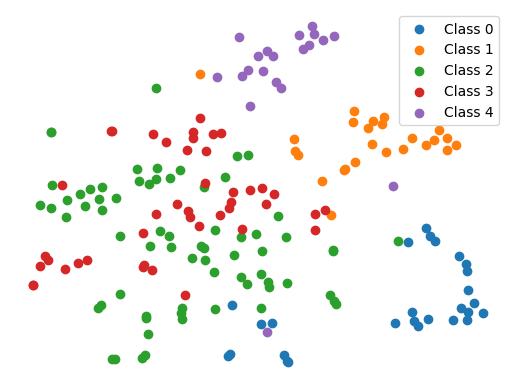

In [ ]:
# Create a scatter plot
plt.figure()

# Get unique labels from y_test
unique_labels = np.unique(predicted_L1_W1)

# Plot the points with different colors for each class
for label in unique_labels:
    indices = np.where(predicted_L1_W1 == label)
    plt.scatter(X_test_tsne[indices, 0], X_test_tsne[indices, 1], label=f'Class {label}')

#plt.title('t-SNE Visualization of X_test')
#plt.xlabel('t-SNE Dimension 1')
#plt.ylabel('t-SNE Dimension 2')

# Add legend
plt.axis("off")
plt.legend()
plt.savefig("MMD_values_70.png")
plt.show()

In [ ]:
data_70["topics"][0].sum()

0.45757685861297015